### Feature Extraction Testing


In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from m2bk import *
import cv2
import importlib

%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(threshold=np.inf, linewidth=np.nan)

In [63]:

dataset_handler = DatasetHandler(100)


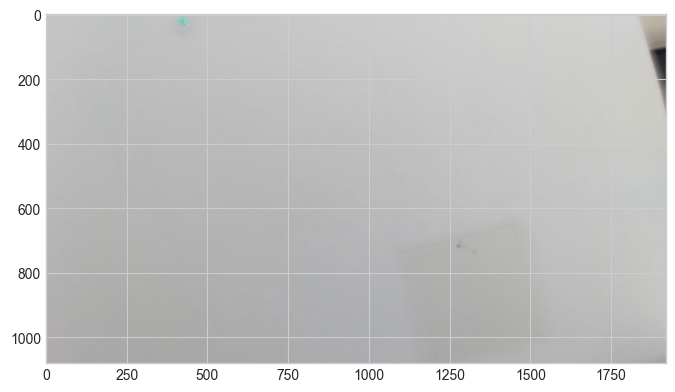

In [64]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

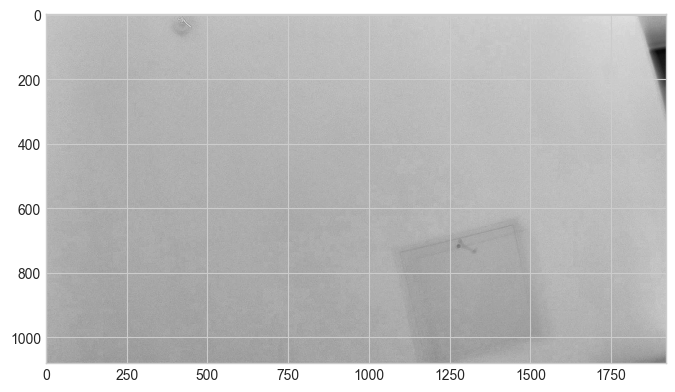

In [65]:


# Function to apply the Sobel filter to the image
def sobel_filter(image):
    # Ensure image is grayscale
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the gradient in the X direction
    sobelx = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    # Calculate the gradient in the Y direction
    sobely = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
    
    # Calculate the magnitude of the gradient
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize to range 0 to 255
    #gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Normalise manually to range 255
    gradient_magnitude = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude)) * 255
    
    # Convert to an unsigned 8-bit type
    edges = np.uint8(gradient_magnitude)
    

    # Increase contrast using histogram equalization
    contrast_enhanced_edges = cv2.equalizeHist(np.uint8(edges))

    # apply a blur filter
    contrast_enhanced_edges = cv2.GaussianBlur(contrast_enhanced_edges, (5, 5), 0)
    
    # set to two tone colour
    ret, contrast_enhanced_edges = cv2.threshold(contrast_enhanced_edges, 200, 255, cv2.THRESH_BINARY)
    
    return contrast_enhanced_edges

def colour_normalise(image):
    # normalise the brightness of the colour image
    # keeping it as a colour image
    image_normalised = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    return image_normalised

def sharpen(image):
    # sharpen the image
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1, 0]])
    image_sharpened = cv2.filter2D(image, -1, kernel)

    # set image to greyscale uint8
    image_sharpened = cv2.cvtColor(image_sharpened, cv2.COLOR_BGR2GRAY)

    #increase contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_sharpened = clahe.apply(image_sharpened)

    
    return image_sharpened


# Apply the Sobel filter to the image
image_sobel = sharpen(image)

# Display the image after applying the Sobel filter
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_sobel, cmap='gray')

In [66]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.03, edgeThreshold=20, )
    kp, des = sift.detectAndCompute(image, None)
    
    return kp, des

def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.grid(False)
    plt.imshow(display)

25 features extracted from the image


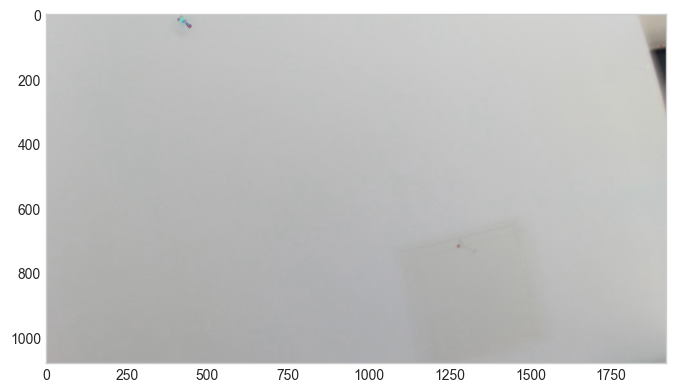

In [67]:
# extract features from the image
kp, des = extract_features(image)

print(f"{len(kp)} features extracted from the image")

# visualize the features
visualize_features(image, kp)

In [69]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    for image in images:
        image = sharpen(image)
        
        kp,des = extract_features_function(image)
        kp_list.append(kp)         
        des_list.append(des)
    
    return kp_list, des_list

In [70]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 689
Coordinates of the first keypoint in frame 0: (5.0393853187561035, 961.27099609375)

Length of images array: 100


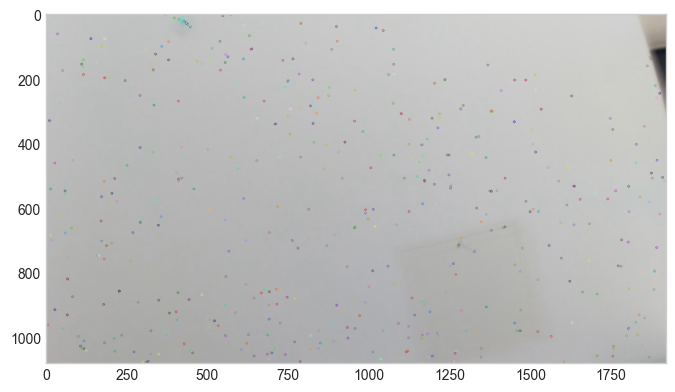

In [71]:
visualize_features(images[0], kp_list[0])

In [72]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm = 1, 
                        trees = 6)
    search_params = dict(checks = 100)
    
    # Initiate FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Find matches with FLANN
    match = flann.knnMatch(des1, des2, k=2)

    match = tuple(m for m in match if len(m) == 2 )
    print("number of matches: ", len(match))

    ### END CODE HERE ###

    return match

In [73]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]



match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

number of matches:  689
Number of features matched in frames 0 and 1: 689


In [77]:
def filter_matches_distance(match, dist_threshold, kp1, kp2):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    ### START CODE HERE ###
    filtered_match = []
    for m,n in match:
        # get the keypoints from kp1 and kp2
        p1 = kp1[m.queryIdx].pt
        p2 = kp2[m.trainIdx].pt
        norm = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
        if (m.distance < dist_threshold * n.distance) and norm < 50:
            filtered_match.append(m) 
    ### END CODE HERE ###
    
    

    return filtered_match

In [78]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 0.6
filtered_match = filter_matches_distance(match, dist_threshold, kp_list[i], kp_list[i+1])

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

number of matches:  689
Number of features matched in frames 0 and 1 after filtering by distance: 0


In [79]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match,None)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

number of matches:  433
(1080, 1920, 3)


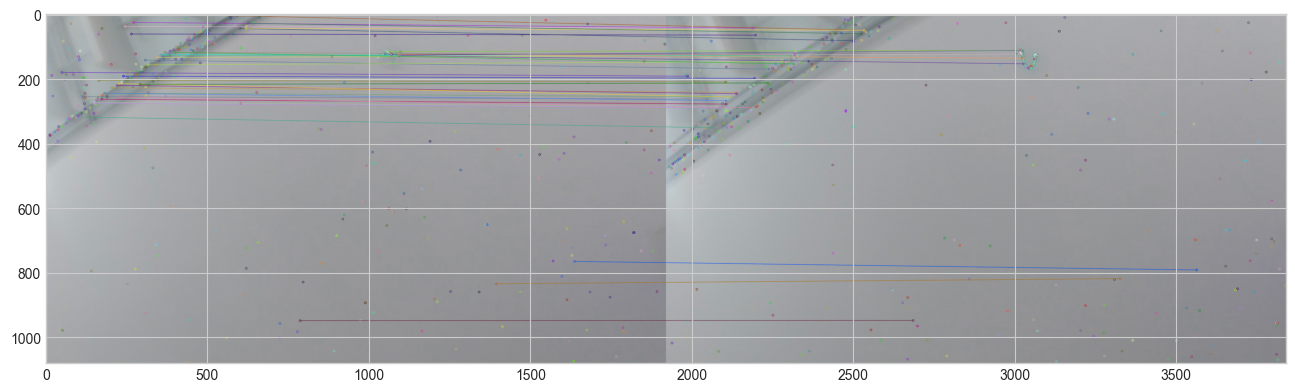

In [80]:
n = None
filtering = True

i = 13
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 1
    match = filter_matches_distance(match, dist_threshold, kp1, kp2)
print(image1.shape)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

In [81]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###
    
    matches = [match_features(des_list[i], des_list[i + 1]) for i in range((len(des_list) - 1))]

    for i in range(0, len(matches)):
        print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

    #for i in range(0, len(matches)):
    #    print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(matches[i])))
    
    ### END CODE HERE ###
    
    return matches

In [82]:
def filter_matches_dataset(filter_matches_distance, kp_list, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = [None] * len(matches)
    
    ### START CODE HERE ###

    for i in range(len(matches)):
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        filtered_matches[i] = filter_matches_distance(matches[i],dist_threshold, kp1, kp2)

    for i in range(0, len(filtered_matches)):
        print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_matches[i])))
    
    ### END CODE HERE ###
    
    return filtered_matches

In [83]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

dist_threshold = 0.5

filtered_matches = filter_matches_dataset(filter_matches_distance, kp_list, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

number of matches:  689
number of matches:  648
number of matches:  564
number of matches:  612
number of matches:  542
number of matches:  459
number of matches:  480
number of matches:  383
number of matches:  440
number of matches:  445
number of matches:  444
number of matches:  360
number of matches:  394
number of matches:  433
number of matches:  457
number of matches:  446
number of matches:  529
number of matches:  459
number of matches:  745
number of matches:  548
number of matches:  538
number of matches:  431
number of matches:  414
number of matches:  447
number of matches:  511
number of matches:  492
number of matches:  629
number of matches:  449
number of matches:  456
number of matches:  506
number of matches:  236
number of matches:  152
number of matches:  124
number of matches:  131
number of matches:  137
number of matches:  186
number of matches:  229
number of matches:  350
number of matches:  368
number of matches:  639
number of matches:  714
number of matche

In [28]:
def convert_point(k, e, u, v, s):
    """
    Convert pixel coordinates to camera coordinates using the pinhole camera model

    Arguments:
    k -- camera calibration matrix 
    e -- essential matrix
    u -- x coordinate of the pixel in the image coordinate system
    v -- y coordinate of the pixel in the image coordinate system
    s -- depth of the object in the camera coordinate system

    Returns:
    p_c -- 3x1 numpy array with the coordinates of the point in the camera coordinate system
    """
    ### START CODE HERE ###
    # Transform pixel coordinates to camera coordinates using the pinhole camera model
    p_c = np.linalg.inv(k) @ (s * np.array([u, v, 1]))

    p_c = p_c @ e
    
    new_u1 = u - k[1,2]
    new_v1 = v - k[0,2]

    print(new_u1, new_v1)

    x = (new_v1 / k[0,0]) * s
    y = (new_u1 / k[1,1]) * s
    z = np.sqrt(s**2 - x**2 - y**2)

    p_c_basic = np.array([x, y, z])

    print(p_c_basic)
    p_c_basic = e @ p_c_basic 
    
    return p_c, p_c_basic


def estimate_motion(img1, img2, match, kp1, kp2, k, depth=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    print(k)

    # Camera extrinsic matrix camera is rotated 10 degrees into the x axis
    cam_ext = np.array([[1, 0, 0], [0, np.cos(np.pi/12), -np.sin(np.pi/12)], [0, np.sin(np.pi/12), np.cos(np.pi/12)]])    

    objectpoints = []
    for m in match:
        # Coordinates of m
        u1, v1 = kp1[m.queryIdx].pt
        u2, v2 = kp2[m.trainIdx].pt
        
        # Get depth
        s = depth[int(v2), int(u2)]
        
        # Transform pixel coordinates to camera coordinates using the pinhole camera model
        p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))

        # new_u1 = u1 - k[0,2]
        # new_v1 = v1 - k[1,2]

        # x = (new_u1 / k[0,0]) * s
        # y = (new_v1 / k[1,1]) * s
        # z = np.sqrt(s**2 - x**2 - y**2)

        #p_c = np.array([x, y, z])
        

        # Rotate by camera extrinsic coordinates
        # p_c = cam_ext @ p_c
        
        # Save the results
        image1_points.append([np.float32(u1), np.float32(v1)])
        image2_points.append([np.float32(u2), np.float32(v2)])
        objectpoints.append(p_c)
        print(kp1[m.queryIdx].pt)
        print(kp2[m.trainIdx].pt)
        print(p_c)
        print(s)
        
    # Convert lists to numpy arrays
    objectpoints = np.vstack(objectpoints, dtype=np.float32)
    imagepoints = np.array(image2_points, dtype=np.float32)
    
    print("Number of points: ", len(objectpoints))

    # plot the points in 3d
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(objectpoints[:,0], objectpoints[:,1], objectpoints[:,2])

    # Determine the camera pose from the Perspective-n-Point solution
    try:
        _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, None)
        rmat, _ = cv2.Rodrigues(rvec)
    except Exception:
        # visualise images and matches
        visualize_matches(image1, kp1, image2, kp2, match[:n])

    # Convert rotation vector to rotation matrix
 
   
    print(rmat)
    print(tvec)

    
    return rmat, tvec, image1_points, image2_points

In [24]:
y_min = 0.75
y_max = -0.75
x_min = 0.5
x_max = -2
xs = np.linspace(x_min, x_max, 1920)
ys = np.linspace(y_max, y_min, 1080)

#depth = [[np.sqrt(xs[1920-(j+1)]**2 + ys[i]**2 + 3**2) for j in range(1920)] for i in range(1080)]
#depth = np.array(depth)

u = 1079
v = 1919

k = dataset_handler.k
e = np.array([[np.cos(np.pi/18), 0,np.sin(np.pi/18)],[0,1,0] ,[-np.sin(np.pi/18), 0, np.cos(np.pi/18)]])

# e = rotation around y axis of pi/12


s = depth[u,v]

print(s)

k = np.array(
        [[1765.4713, 0, 1500], [0, 1756.59718, 540], [0, 0, 1]],
        dtype=np.float32,
    )

p_c, p_c_basic = convert_point(k, e, u, v, s)

print(p_c)
print(p_c_basic)

3.1881500000000003
539.0 419.0
[0.75664489 0.97826234 2.93850161]
[-1.30232311  2.50282718  3.00769765]
[1.25541521 0.97826234 2.76246916]


[[1.7654713e+03 0.0000000e+00 9.1383716e+02]
 [0.0000000e+00 1.7565972e+03 6.0983954e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
(125.75409698486328, 856.5718383789062)
(144.95237731933594, 863.306884765625)
[-0.92869593  0.29222411  2.08047348]
2.0804734757686294
(144.45730590820312, 428.6068115234375)
(122.29593658447266, 424.9544372558594)
[-0.9044536  -0.21412658  2.07542058]
2.075420583637311
(159.46945190429688, 209.51040649414062)
(179.9034423828125, 201.7940216064453)
[-0.8923998  -0.47597269  2.08851217]
2.088512167795727
(159.8626251220703, 695.9335327148438)
(167.3733673095703, 698.231689453125)
[-0.89075764  0.10222667  2.08575604]
2.0857560448150076
(161.0349578857422, 515.293212890625)
(166.82781982421875, 511.35235595703125)
[-0.88927469 -0.11225047  2.08552637]
2.0855263678999476
(167.5636444091797, 656.5340576171875)
(175.899658203125, 654.9343872070312)
[-0.88243621  0.05549319  2.08759346]
2.087593460135487
(176.7446746826172, 762.8131103515625)
(194.734756469

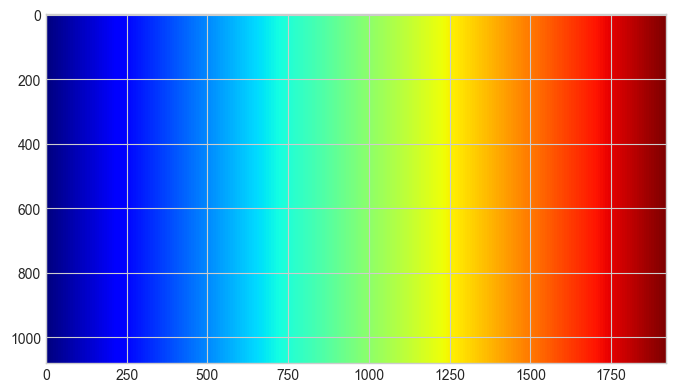

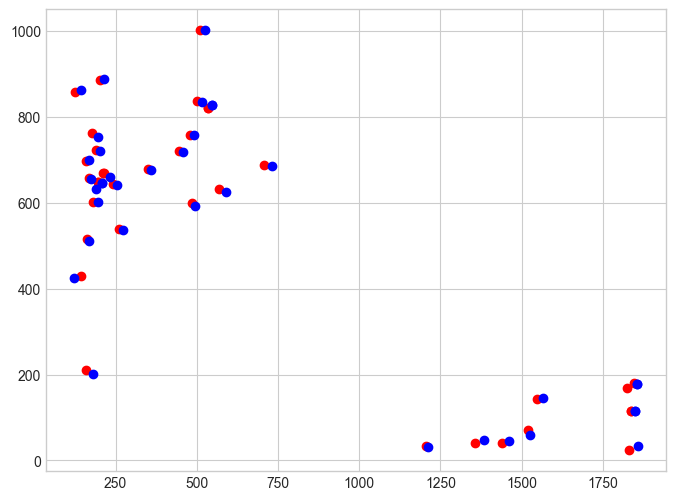

Estimated rotation:
 [[ 9.99973771e-01  7.22139281e-03  5.55420653e-04]
 [-7.23927279e-03  9.98920470e-01  4.58855853e-02]
 [-2.23463224e-04 -4.58884026e-02  9.98946547e-01]]
Estimated translation:
 [[ 0.02273024]
 [-0.10678463]
 [-0.02108005]]


In [94]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
y_min = 0.75
y_max = -0.75
x_min = 0.5
x_max = -2
ceiling_height = 2.4
xs = np.linspace(x_min, x_max, 1920)
depth = [[(0.1763 * xs[1920-(j+1)] + ceiling_height) for j in range(1920)] for _ in range(1080)]
depth = np.array(depth)
#print(depth)

#make a depth heatmap
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

rmat, tvec, image1_points, image2_points = estimate_motion(images[i], images[i +1] ,match, kp1, kp2, k, depth)

# plot the x and y coordinates of the points
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter([p[0] for p in image1_points], [p[1] for p in image1_points], c='r')
plt.scatter([p[0] for p in image2_points], [p[1] for p in image2_points], c='b')
plt.show()

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

[[1.7654713e+03 0.0000000e+00 9.1383716e+02]
 [0.0000000e+00 1.7565972e+03 6.0983954e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
(624.1146240234375, 102.48651123046875)
(626.1283569335938, 136.4737091064453)
[-0.47445662 -0.83505078  2.89117775]
2.8911777488275145
(1134.24951171875, 329.16943359375)
(1151.86328125, 338.2015686035156)
[ 0.37600634 -0.48122046  3.01175813]
3.011758129233976
(1172.748046875, 282.08746337890625)
(1188.6407470703125, 288.4557800292969)
[ 0.44292813 -0.56353003  3.02025618]
3.0202561750911934
(1197.6497802734375, 260.2906799316406)
(1188.6407470703125, 288.4557800292969)
[ 0.48552844 -0.60100696  3.02025618]
3.0202561750911934
(1206.894775390625, 252.34796142578125)
(1188.6407470703125, 288.4557800292969)
[ 0.50134418 -0.61466351  3.02025618]
3.0202561750911934
(1324.7086181640625, 145.45169067382812)
(1332.2318115234375, 144.62574768066406)
[ 0.71058968 -0.80720227  3.05332965]
3.053329650859823
(1332.901611328125, 155.23159790039062)
(1340.582275390

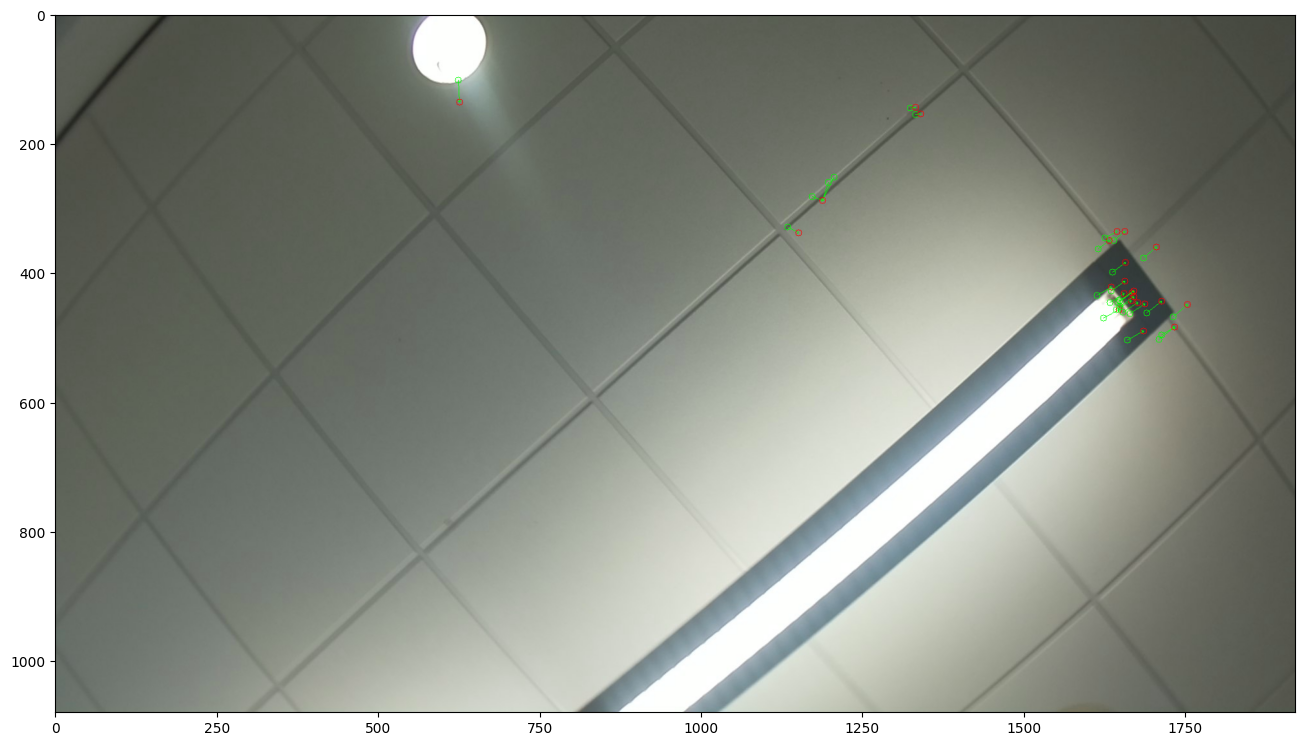

In [30]:
i = 0
image1  = dataset_handler.images[i]
image2 = dataset_handler.images[i + 1]

match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]

rmat, tvec, image1_points, image2_points = estimate_motion(images[i], images[i +1] ,match, kp1, kp2, k, depth)
print(rmat, tvec)

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

In [31]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth, save=''):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition
    save -- a path to store camera movement images, it will not save images by default

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """        
    # Create variables for computation
    trajectory = np.zeros((3, len(matches) + 1))
    robot_pose = np.zeros((len(matches) + 1, 4, 4))
    
    # Initialize camera pose
    robot_pose[0] = np.eye(4)


    # x_min = -1.645
    # x_max = 1.645
    # y_min = -0.045
    # y_max = 2.765
    # xs = np.linspace(x_min, x_max, 1920)
    # ys = np.linspace(y_max, y_min, 1080)
    # depth = [[np.sqrt(xs[j]**2 + ys[i]**2 + 3.1**2) for j in range(1920)] for i in range(1080)]
    # depth = np.array(depth)
    
    # Iterate through the matched features
    for i in range(len(matches)):
        # Estimate camera motion between a pair of images
        rmat, tvec, image1_points, image2_points = estimate_motion(dataset_handler.images[i], dataset_handler.images[i +1], matches[i], kp_list[i], kp_list[i + 1], k, depth)
        
        
        # Save camera movement visualization
        if save:
            image = visualize_camera_movement(dataset_handler.images[i], image1_points, dataset_handler.images[i + 1], image2_points)
            plt.imsave('{}/frame_{:02d}.jpg'.format(save, i), image)
        
        # Determine current pose from rotation and translation matrices
        current_pose = np.eye(4)
        current_pose[0:3, 0:3] = rmat
        current_pose[0:3, 3] = tvec.T
        
        # Build the robot's pose from the initial position by multiplying previous and current poses
        robot_pose[i + 1] = robot_pose[i] @ np.linalg.inv(current_pose)

        # if any of the dimensions change by more than 0.2 then ignore
        
        if np.any(np.abs(robot_pose[i + 1][0:3, 3] - robot_pose[i][0:3, 3]) > 0.2):
            if (last_pose is not None):
                robot_pose[i + 1] = robot_pose[i] @ np.linalg.inv(last_pose)
            else:
                robot_pose[i + 1] = robot_pose[i]
        else:
            last_pose = current_pose
        
        # Calculate current camera position from origin
        position = robot_pose[i + 1] @ np.array([0., 0., 0., 1.])
        
        # Build trajectory
        trajectory[:, i + 1] = position[0:3]

        
        
    return trajectory

[[1.7654713e+03 0.0000000e+00 9.1383716e+02]
 [0.0000000e+00 1.7565972e+03 6.0983954e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
(624.1146240234375, 102.48651123046875)
(626.1283569335938, 136.4737091064453)
[-0.47445662 -0.83505078  2.89117775]
2.8911777488275145
(1134.24951171875, 329.16943359375)
(1151.86328125, 338.2015686035156)
[ 0.37600634 -0.48122046  3.01175813]
3.011758129233976
(1172.748046875, 282.08746337890625)
(1188.6407470703125, 288.4557800292969)
[ 0.44292813 -0.56353003  3.02025618]
3.0202561750911934
(1197.6497802734375, 260.2906799316406)
(1188.6407470703125, 288.4557800292969)
[ 0.48552844 -0.60100696  3.02025618]
3.0202561750911934
(1206.894775390625, 252.34796142578125)
(1188.6407470703125, 288.4557800292969)
[ 0.50134418 -0.61466351  3.02025618]
3.0202561750911934
(1324.7086181640625, 145.45169067382812)
(1332.2318115234375, 144.62574768066406)
[ 0.71058968 -0.80720227  3.05332965]
3.053329650859823
(1332.901611328125, 155.23159790039062)
(1340.582275390

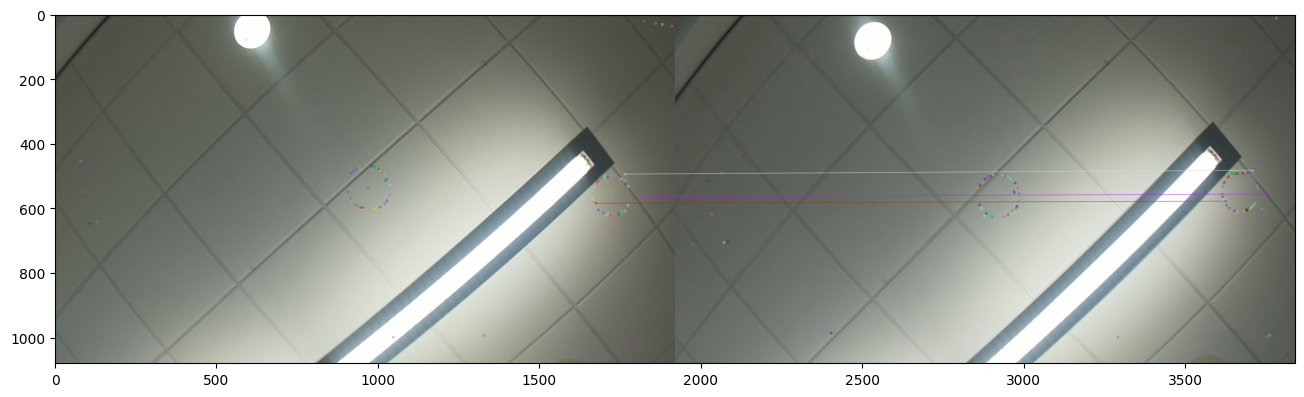

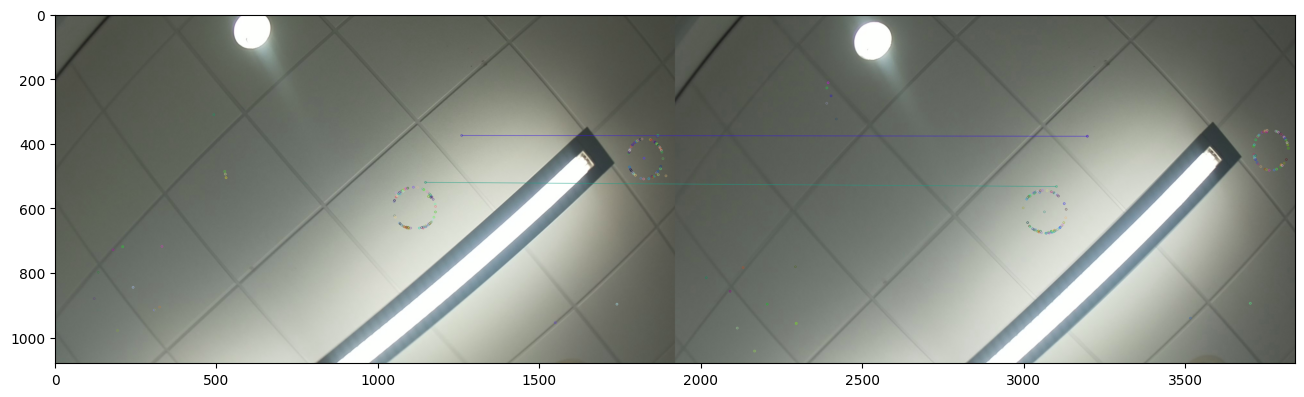

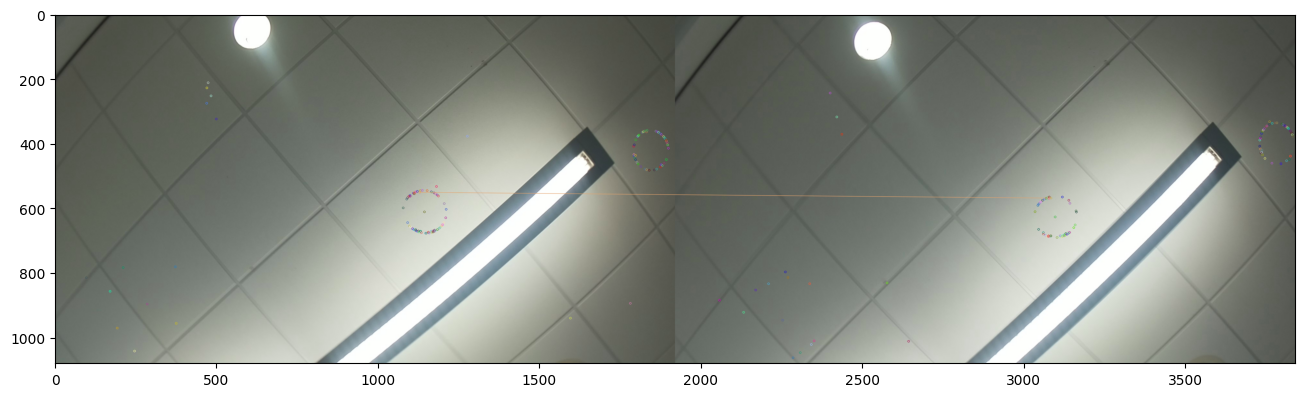

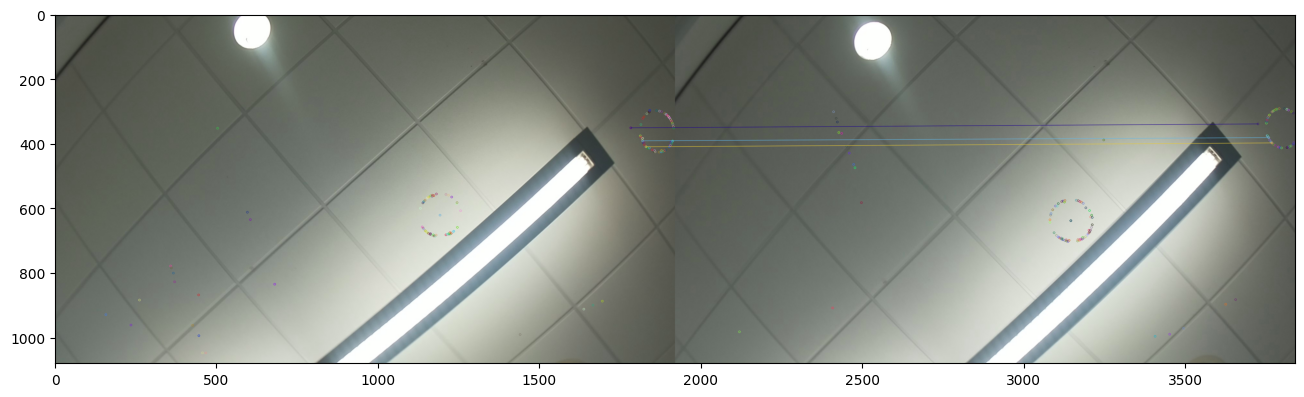

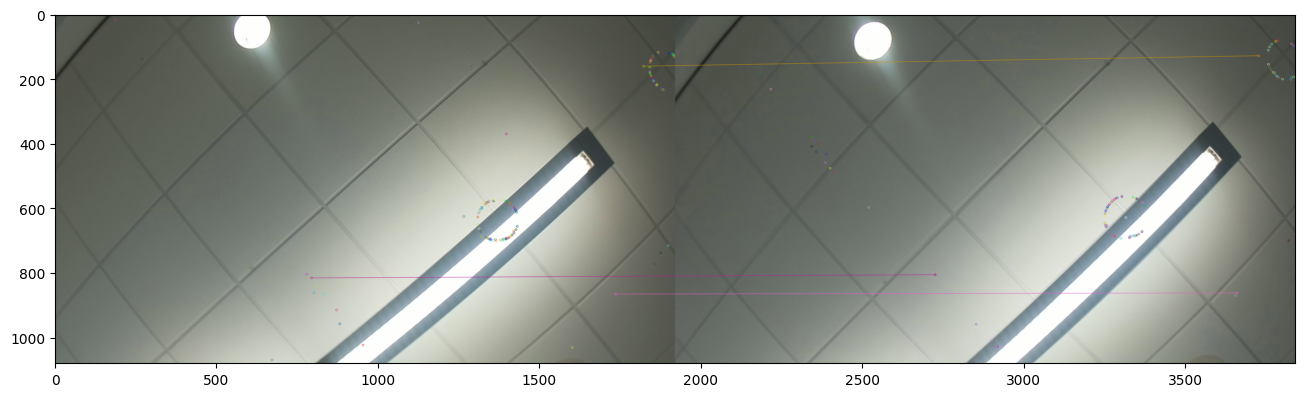

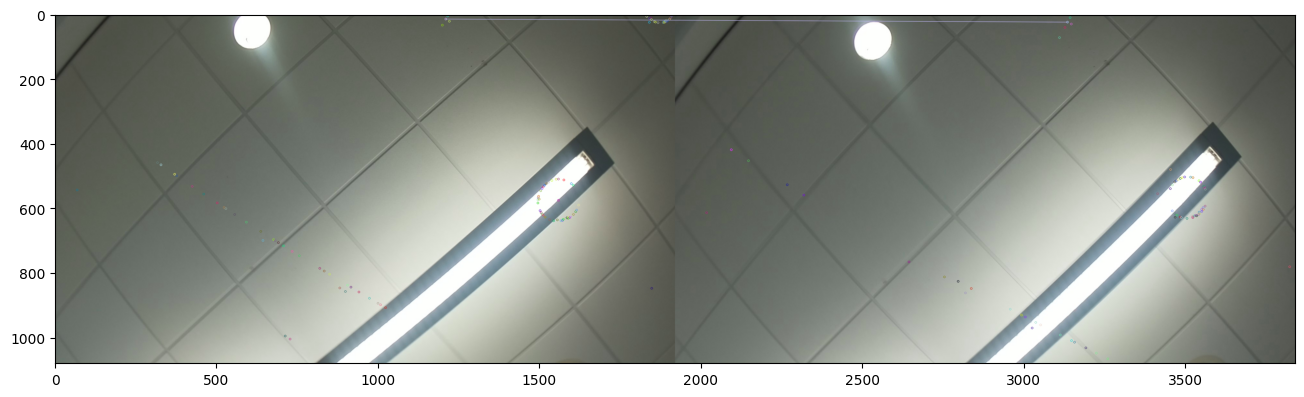

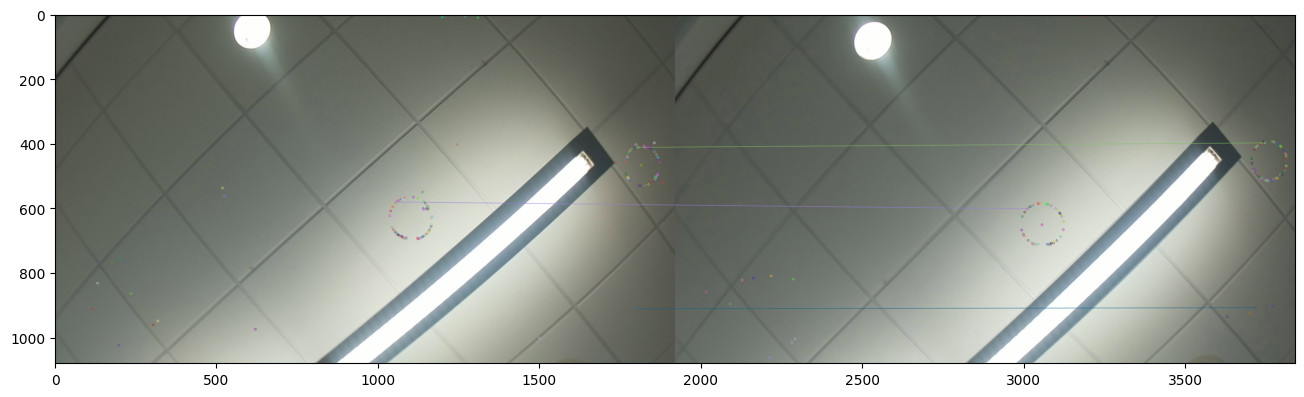

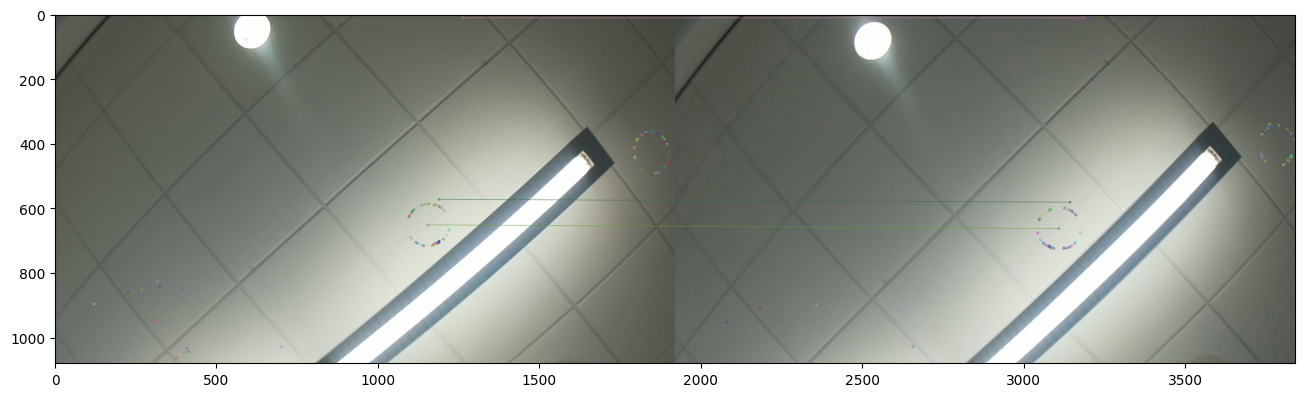

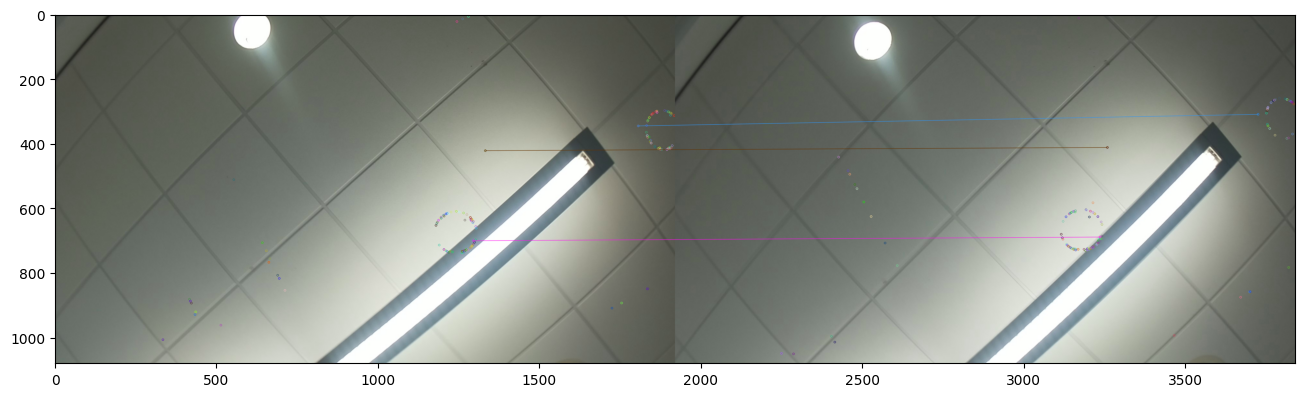

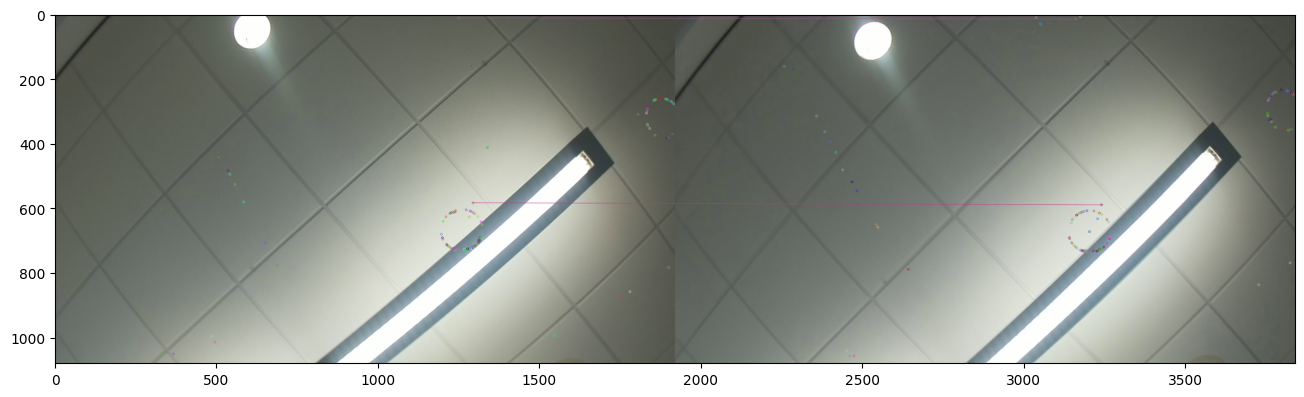

In [32]:
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

In [95]:
dataset_handler = DatasetHandler(80)

images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.8
    filtered_matches = filter_matches_dataset(filter_matches_distance, kp_list, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation
#depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth)

number of matches:  499
number of matches:  308
number of matches:  503
number of matches:  468
number of matches:  367
number of matches:  350
number of matches:  545
number of matches:  505
number of matches:  525
number of matches:  398
number of matches:  574
number of matches:  420
number of matches:  370
number of matches:  853
number of matches:  632
number of matches:  670
number of matches:  613
number of matches:  378
number of matches:  484
number of matches:  683
number of matches:  842
number of matches:  811
number of matches:  523
number of matches:  499
number of matches:  957
number of matches:  508
number of matches:  439
number of matches:  582
number of matches:  567
number of matches:  854
number of matches:  692
number of matches:  594
number of matches:  654
number of matches:  647
number of matches:  1000
number of matches:  670
number of matches:  1000
number of matches:  762
number of matches:  1000
number of matches:  955
number of matches:  536
number of mat

In [37]:
for i in range(trajectory.shape[1]):
    print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

Camera location in point 0 is: 
 [[0.]
 [0.]
 [0.]]

Camera location in point 1 is: 
 [[-0.01676702]
 [ 0.01940738]
 [-0.0111463 ]]

Camera location in point 2 is: 
 [[-0.1266007 ]
 [ 0.04103479]
 [ 0.04793559]]

Camera location in point 3 is: 
 [[-0.18791505]
 [ 0.0954969 ]
 [ 0.07729101]]

Camera location in point 4 is: 
 [[-0.23031052]
 [ 0.03849983]
 [ 0.08009289]]

Camera location in point 5 is: 
 [[-0.30776841]
 [-0.03498645]
 [ 0.11319757]]

Camera location in point 6 is: 
 [[-0.37044582]
 [-0.09952781]
 [ 0.13090575]]

Camera location in point 7 is: 
 [[-0.44514796]
 [-0.15302477]
 [ 0.15998571]]

Camera location in point 8 is: 
 [[-0.41296828]
 [-0.08247397]
 [ 0.08338279]]

Camera location in point 9 is: 
 [[-0.50445564]
 [-0.05194355]
 [ 0.11567741]]

Camera location in point 10 is: 
 [[-0.52689838]
 [-0.11925953]
 [ 0.11651594]]

Camera location in point 11 is: 
 [[-0.54646494]
 [-0.1549532 ]
 [ 0.11793502]]

Camera location in point 12 is: 
 [[-0.594886  ]
 [-0.17207263]
 

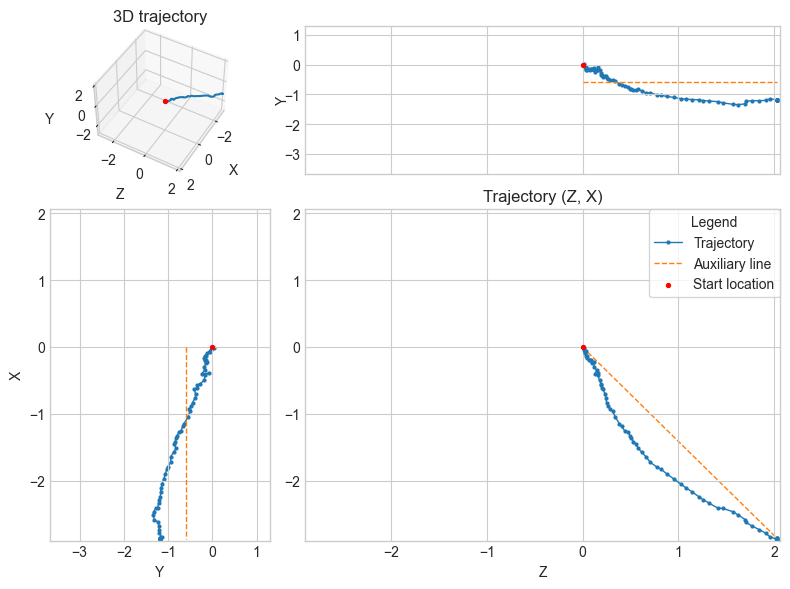

In [96]:
visualize_trajectory(trajectory)

[0. 0. 0.]


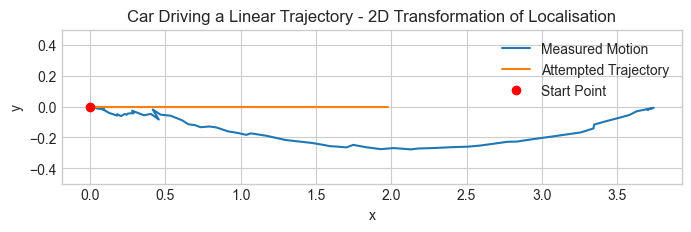

In [120]:
from sklearn.decomposition import PCA

def plot_2d_principal_components(points_3d):
    """
    Takes a list of points in 3D, calculates their 2 dimensions of greatest variance (principal components),
    and plots the data in these dimensions.
    
    Parameters:
    - points_3d: A list or numpy array of shape (n, 3) where n is the number of points, and 3 represents the 3D coordinates.
    """
    # Convert the input list to a numpy array if it's not already
    points_3d = np.array(points_3d)
    print(points_3d[0])
    
    # Ensure the input is of the correct shape
    if points_3d.shape[1] != 3:
        raise ValueError("The input must be a list or array of 3D points.")
    
    # Calculate the covariance matrix without centering the data
    C = np.cov(points_3d, rowvar=False, bias=True)
    
    # Perform eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(C)
    
    # Sort eigenvectors by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Project the data onto the first two principal components
    points_2d = points_3d.dot(eigenvectors[:, :2])

    # Flip the y axis
    #points_2d[:, 1] *= -1
    
    from Utils.state import State
    from Utils.action import Action
    from Utils.trajectory import Trajectory
    from Models.robot import Robot
    
    car = Robot()

    action = Action(0, 0.5, car)
    action2 = Action(0, 0, car)
    state = State(0,0, -np.pi, 1 )
    actions = [action for i in range(0, 6)] + [action2 for i in range(0, 10)]

    
    # Plotting the points in the new 2D space
    plt.figure(figsize=(8, 2))
    plt.plot(points_2d[:, 0], points_2d[:, 1])
    #plot the start point

    cur_state = State(0,0, 0, 1 )
    x = [cur_state.x]
    y = [cur_state.y]
    for action in actions:
        new_state = action.apply(cur_state)
        x.append(new_state.x)
        y.append(new_state.y)
        cur_state = new_state
    plt.plot(x, y)
    
    plt.plot(points_2d[0, 0], points_2d[0, 1], 'ro')

    plt.title("Car Driving a Linear Trajectory - 2D Transformation of Localisation")
    plt.ylim(-0.5,0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    # add a legend
    plt.legend(["Measured Motion", "Attempted Trajectory", "Start Point"])
    plt.grid(True)
    plt.show()

# Plot the 2D principal components of the trajectory
plot_2d_principal_components(trajectory.T)


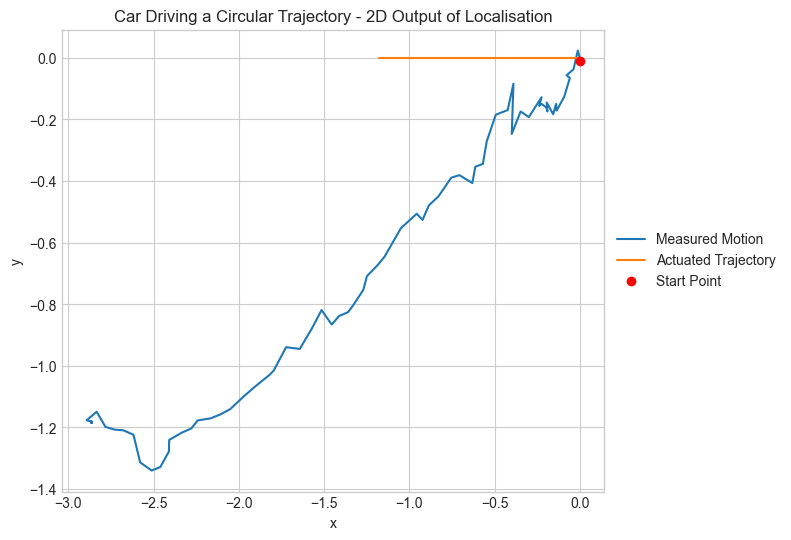

In [109]:
# take first two dimensions and plot

# plot the trajectory in 2D
plt.figure(figsize=(7, 6))
plt.plot(trajectory[0], trajectory[1])



cur_state = State(0,0, -np.pi, 1 )
x = [cur_state.x]
y = [cur_state.y]
for action in actions:
    new_state = action.apply(cur_state)
    x.append(new_state.x)
    y.append(new_state.y)
    cur_state = new_state
plt.plot(x, y)
plt.plot(trajectory[0, 0], trajectory[0, 1], 'ro')

plt.title("Car Driving a Circular Trajectory - 2D Transformation of Localisation")
plt.xlabel("x")
plt.ylabel("y")
# add a legend
plt.legend(
    ["Measured Motion", "Attempted Trajectory", "Start Point"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.grid(True)
plt.show()